# Title

### Objective
A recruiting team has been tasked to hire new members for their company's Data Science department from a pool of candidates currently enrolled in a skills development program. The recruiting team would like a model to be built that will highlight the enrollees who are most likely to be interested in a career change and therefore should be targeted for recruitment. The recruitment process consumes a lot of time and resources so the model must be accurate to at least 80% and focus on the precision of it's classification. The recruiting team has provided a list of enrollees that includes various pieces of information about them and whether they would be considered a target or not along with a preliminary list of enrollees that need to be classified. 

### Introduction
This project will walk through the process of building and testing various machine learning models to accomplished the objective stated above. It begins with null value treatment followed by exploratory data analysis and feature engineering. We then build and test two linear models, logistic and support vector, as well as K-nearest Neighbors, Decision Tree, Random Forrest, and finally a bagged model. Each model goes through hyperparameter optimization and some cross validation. These models are then compared based on their accuracy, precision, recall, and run time to determine the best fit for our objective. 

In [1]:
# Basic Packages
import pandas as pd
import numpy as np
import seaborn as sns
import time
import joblib
import os.path
import matplotlib.pyplot as plt

# Feature Analysis
from imblearn.over_sampling import SMOTE
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

# Model Evaluation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set style colours for figures
sns.set_style(style = 'dark')
sns.set_palette(palette = 'winter')

In [3]:
hrTrain = pd.read_csv('aug_train.csv')
hrTrain

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19153,7386,city_173,0.878,Male,No relevent experience,no_enrollment,Graduate,Humanities,14,NaN,NaN,1,42,1.0
19154,31398,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,NaN,NaN,4,52,1.0
19155,24576,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,4,44,0.0
19156,5756,city_65,0.802,Male,Has relevent experience,no_enrollment,High School,NaN,<1,500-999,Pvt Ltd,2,97,0.0


In [4]:
hrTest = pd.read_csv('aug_test.csv')
hrTest

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,32403,city_41,0.827,Male,Has relevent experience,Full time course,Graduate,STEM,9,<10,NaN,1,21
1,9858,city_103,0.920,Female,Has relevent experience,no_enrollment,Graduate,STEM,5,NaN,Pvt Ltd,1,98
2,31806,city_21,0.624,Male,No relevent experience,no_enrollment,High School,NaN,<1,NaN,Pvt Ltd,never,15
3,27385,city_13,0.827,Male,Has relevent experience,no_enrollment,Masters,STEM,11,10/49,Pvt Ltd,1,39
4,27724,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,10000+,Pvt Ltd,>4,72
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2124,1289,city_103,0.920,Male,No relevent experience,no_enrollment,Graduate,Humanities,16,NaN,Public Sector,4,15
2125,195,city_136,0.897,Male,Has relevent experience,no_enrollment,Masters,STEM,18,NaN,NaN,2,30
2126,31762,city_100,0.887,Male,No relevent experience,no_enrollment,Primary School,NaN,3,NaN,Pvt Ltd,never,18
2127,7873,city_102,0.804,Male,Has relevent experience,Full time course,High School,NaN,7,100-500,Public Sector,1,84


In [5]:
print('Train Dataset Shape: ', hrTrain.shape)
print('Test Dataset Shape: ', hrTest.shape)

Train Dataset Shape:  (19158, 14)
Test Dataset Shape:  (2129, 13)


In [6]:
hrTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

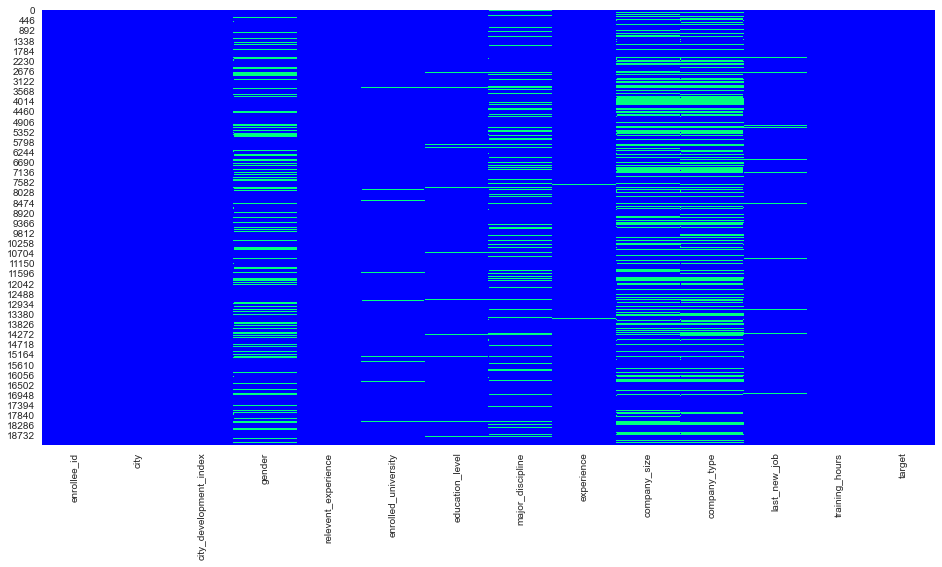

In [7]:
plt.figure(figsize= (16,8))
sns.heatmap(hrTrain.isnull(), cbar = False, cmap = 'winter')
plt.show()

In [8]:
nullTotalDF = pd.DataFrame(hrTrain.isnull().sum()).reset_index()
nullTotalDF.columns = ['Category', 'Total Null']
nullPercentDF = pd.DataFrame(round(hrTrain.isnull().sum()/hrTrain.shape[0]*100,2)).reset_index()
nullPercentDF.columns = ['Category', 'Percent Null']
nullDF = pd.merge(nullTotalDF, nullPercentDF, on = 'Category')
nullDF.sort_values('Percent Null', ascending = False)

,Category,Total Null,Percent Null
10,company_type,6140,32.05
9,company_size,5938,30.99
3,gender,4508,23.53
7,major_discipline,2813,14.68
6,education_level,460,2.40
11,last_new_job,423,2.21
5,enrolled_university,386,2.01
8,experience,65,0.34
0,enrollee_id,0,0.00
1,city,0,0.00


We'll likely end up removing all the columns with more than 30% null values but that decision will be made after further inspection of each column.

In [9]:
hrTrain['gender'].value_counts(dropna = False)

Male      13221
NaN        4508
Female     1238
Other       191
Name: gender, dtype: int64

In [10]:
hrTest['gender'].value_counts(dropna = False)

Male      1460
NaN        508
Female     137
Other       24
Name: gender, dtype: int64

Since the second largest category in the gender columns is 'no answer' we'll assume that many people who do not identify as a male did not want to disclose that gender information. For the purpose of our model we'll change the entries in this columns from 'Male' to 'Male ID' for those who identified as Male and to 'Non-Male ID' for all other entries for those who did not choose to identify as male.

In [11]:
hrTrain['gender'].replace({'Male':'Male ID', 'Female':'Non-Male ID', 'Other':'Non-Male ID'}, inplace = True)
hrTrain['gender'].fillna('Non-Male ID', inplace = True)
hrTrain['gender'].value_counts(dropna = False)

Male ID        13221
Non-Male ID     5937
Name: gender, dtype: int64

In [12]:
hrTest['gender'].replace({'Male':'Male ID', 'Female':'Non-Male ID', 'Other':'Non-Male ID'}, inplace = True)
hrTest['gender'].fillna('Non-Male ID', inplace = True)
hrTest['gender'].value_counts(dropna = False)

Male ID        1460
Non-Male ID     669
Name: gender, dtype: int64

In [13]:
hrTrain['enrolled_university'].value_counts(dropna = False)

no_enrollment       13817
Full time course     3757
Part time course     1198
NaN                   386
Name: enrolled_university, dtype: int64

In [14]:
hrTest['enrolled_university'].value_counts(dropna = False)

no_enrollment       1519
Full time course     435
Part time course     144
NaN                   31
Name: enrolled_university, dtype: int64

We'll change any null values for the 'enrolled_university' column to 'Other'.

In [15]:
hrTrain['enrolled_university'].fillna('Other', inplace = True)
hrTrain['enrolled_university'].value_counts(dropna = False)

no_enrollment       13817
Full time course     3757
Part time course     1198
Other                 386
Name: enrolled_university, dtype: int64

In [16]:
hrTest['enrolled_university'].fillna('Other', inplace = True)
hrTest['enrolled_university'].value_counts(dropna = False)

no_enrollment       1519
Full time course     435
Part time course     144
Other                 31
Name: enrolled_university, dtype: int64

In [17]:
hrTrain['education_level'].value_counts(dropna = False)

Graduate          11598
Masters            4361
High School        2017
NaN                 460
Phd                 414
Primary School      308
Name: education_level, dtype: int64

In [18]:
hrTest['education_level'].value_counts(dropna = False)

Graduate          1269
Masters            496
High School        222
Phd                 54
NaN                 52
Primary School      36
Name: education_level, dtype: int64

We'll change the null values in the education level to 'Other' since we can't assume the education level of those who did not fill out this section.

In [19]:
hrTrain['education_level'].fillna('Other', inplace = True)
hrTrain['education_level'].value_counts(dropna = False)

Graduate          11598
Masters            4361
High School        2017
Other               460
Phd                 414
Primary School      308
Name: education_level, dtype: int64

In [20]:
hrTest['education_level'].fillna('Other', inplace = True)
hrTest['education_level'].value_counts(dropna = False)


Graduate          1269
Masters            496
High School        222
Phd                 54
Other               52
Primary School      36
Name: education_level, dtype: int64

In [21]:
hrTrain['major_discipline'].value_counts(dropna = False)

STEM               14492
NaN                 2813
Humanities           669
Other                381
Business Degree      327
Arts                 253
No Major             223
Name: major_discipline, dtype: int64

In [22]:
hrTest['major_discipline'].value_counts(dropna = False)

STEM               1621
NaN                 312
Humanities           80
Other                40
Business Degree      37
No Major             22
Arts                 17
Name: major_discipline, dtype: int64

We have more null values than many of the alternative options that were presented to the enrollees. We'll change this category into a binary classification where the education major is either STEM or Non-STEM,

In [23]:
hrTrain['major_discipline'].replace(dict.fromkeys(['Humanities', 'Other', 'Business Degree', 'No Major', 'Arts'], 'Non-STEM'), inplace = True)
hrTrain['major_discipline'].fillna('Non-STEM', inplace = True)
hrTrain['major_discipline'].value_counts(dropna = False)

STEM        14492
Non-STEM     4666
Name: major_discipline, dtype: int64

In [24]:
hrTest['major_discipline'].replace(dict.fromkeys(['Humanities', 'Other', 'Business Degree', 'No Major', 'Arts'], 'Non-STEM'), inplace = True)
hrTest['major_discipline'].fillna('Non-STEM', inplace = True)
hrTest['major_discipline'].value_counts(dropna = False)

STEM        1621
Non-STEM     508
Name: major_discipline, dtype: int64

In [25]:
hrTrain['experience'].value_counts(dropna = False)

>20    3286
5      1430
4      1403
3      1354
6      1216
2      1127
7      1028
10      985
9       980
8       802
15      686
11      664
14      586
1       549
<1      522
16      508
12      494
13      399
17      342
19      304
18      280
20      148
NaN      65
Name: experience, dtype: int64

There are relatively few null values for years of experience but simply setting these all to 'Other' like we had done with other categories does not make sense with these numeric values. Let's set them to the average of our set which requires us to do some additional manipulation to find out what that average is since we have some non-numeric values as well as them currently being strings. 

In [26]:
exp = hrTrain['experience'].dropna().tolist()
for i in range(0, len(exp)):
    if exp[i] == '<1':
        exp[i] = '0'
    elif exp[i] == '>20':
        exp[i] = '21'
    exp[i] = int(exp[i])
mean = round(sum(exp)/len(exp),1)
print("The mean years of experience is: ",mean)

The mean years of experience is:  10.1


In [27]:
hrTrain['experience'].fillna('10', inplace = True)

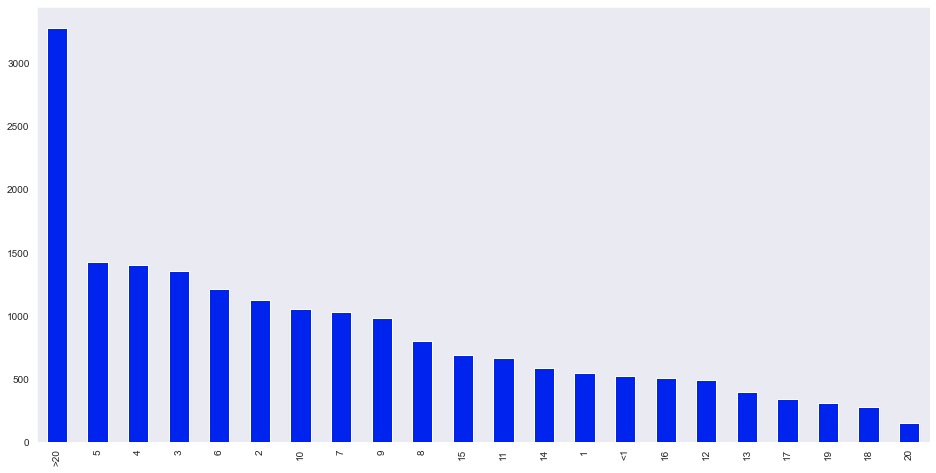

In [28]:
hrTrain['experience'].value_counts().plot(kind = 'bar', figsize = (16,8))

The years of experience metric is little flawed as it is both very specific and very broad. Let's see what the distribution looks like if we bin the experience into 7 year buckets to try and group enrollees that are in similar stages of their professional careers.

In [29]:
hrTrain['experience'].replace(dict.fromkeys(['<1', '1', '2', '3', '4'], '<5'), inplace = True)
hrTrain['experience'].replace(dict.fromkeys(['8', '9', '5', '6', '7'], '5-9'), inplace = True)
hrTrain['experience'].replace(dict.fromkeys(['10','11', '12', '13', '14'], '10-14'), inplace = True)
hrTrain['experience'].replace(dict.fromkeys(['15', '16', '17', '18', '19', '20'], '15-20'), inplace = True)
hrTrain['experience'].value_counts()

5-9      5456
<5       4955
>20      3286
10-14    3193
15-20    2268
Name: experience, dtype: int64

In [30]:
hrTest['experience'].fillna('10', inplace = True)
hrTest['experience'].replace(dict.fromkeys(['<1', '1', '2', '3', '4'], '<5'), inplace = True)
hrTest['experience'].replace(dict.fromkeys(['8', '9', '5', '6', '7'], '5-9'), inplace = True)
hrTest['experience'].replace(dict.fromkeys(['10','11', '12', '13', '14'], '10-14'), inplace = True)
hrTest['experience'].replace(dict.fromkeys(['15', '16', '17', '18', '19', '20'], '15-20'), inplace = True)
hrTest['experience'].value_counts()

5-9      604
<5       557
>20      383
10-14    348
15-20    237
Name: experience, dtype: int64

In [31]:
hrTrain['company_size'].value_counts(dropna = False)

NaN          5938
50-99        3083
100-500      2571
10000+       2019
10/49        1471
1000-4999    1328
<10          1308
500-999       877
5000-9999     563
Name: company_size, dtype: int64

In [32]:
hrTest['company_size'].value_counts(dropna = False)

NaN          622
50-99        338
100-500      318
10000+       217
10/49        172
<10          163
1000-4999    143
500-999       88
5000-9999     68
Name: company_size, dtype: int64

There are more null values than any other of the numeric buckets for the 'company_size' category. We cannot use an average because it is the number one category and using 'Other' isn't a valid option. We will frop the company_size category altogether.

In [33]:
hrTrain.drop(['company_size'], axis = 1, inplace = True)
hrTest.drop(['company_size'], axis = 1, inplace = True)

In [34]:
hrTrain['company_type'].value_counts(dropna = False)

Pvt Ltd                9817
NaN                    6140
Funded Startup         1001
Public Sector           955
Early Stage Startup     603
NGO                     521
Other                   121
Name: company_type, dtype: int64

We will set the null values in the 'company_type' to the existing 'Other' category.

In [35]:
hrTrain.fillna('Other', inplace = True)
hrTest.fillna('Other', inplace = True)

In [36]:
hrTrain.isnull().sum()

enrollee_id               0
city                      0
city_development_index    0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_type              0
last_new_job              0
training_hours            0
target                    0
dtype: int64

In [37]:
hrTest.isnull().sum()

enrollee_id               0
city                      0
city_development_index    0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_type              0
last_new_job              0
training_hours            0
dtype: int64

In [38]:
hrTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  19158 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     19158 non-null  object 
 6   education_level         19158 non-null  object 
 7   major_discipline        19158 non-null  object 
 8   experience              19158 non-null  object 
 9   company_type            19158 non-null  object 
 10  last_new_job            19158 non-null  object 
 11  training_hours          19158 non-null  int64  
 12  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(9)
memory usage: 1.9+ MB


In [39]:
hrTrain['enrollee_id'].value_counts(normalize=True)

2047     0.000052
2692     0.000052
4743     0.000052
27272    0.000052
25225    0.000052
           ...   
17682    0.000052
19731    0.000052
29972    0.000052
25878    0.000052
6147     0.000052
Name: enrollee_id, Length: 19158, dtype: float64

The `enrollee_id` is unique to each row/entry so it can be removed

In [40]:
hrTrain.drop('enrollee_id', axis = 1, inplace = True)
hrTest.drop('enrollee_id', axis = 1, inplace = True)

In [41]:
hrTrain['city'].value_counts(normalize=True)

city_103    0.227320
city_21     0.141038
city_16     0.080019
city_114    0.069736
city_160    0.044107
              ...   
city_111    0.000157
city_129    0.000157
city_121    0.000157
city_171    0.000052
city_140    0.000052
Name: city, Length: 123, dtype: float64

Geographic location doesn't fit our objective and it is very likely we run into an enrollee that does not work in one of the 123 cites from the original dataset. This means that this metric is not useful and it will cause issues at some point so we will remove it from the dataset.

In [42]:
hrTrain.drop('city', axis = 1, inplace = True)
hrTest.drop('city', axis = 1, inplace = True)

### EDA

In [43]:
def univar(column, width = 0.2):
    labels = np.unique(hrTrain[column].tolist())
    targetList = []
    nonTargetList = []
    percents = []
    width = width
    labelLen = np.arange(len(labels))

    for i in labels:
        colCountTarget = len(hrTrain.loc[(hrTrain[column] == i) & (hrTrain['target'] == 1)])
        targetList.append(colCountTarget)
        colCountNotTarget = len(hrTrain.loc[(hrTrain[column] == i) & (hrTrain['target'] == 0)])
        nonTargetList.append(colCountNotTarget)
        perCol = round(colCountTarget/(colCountTarget+colCountNotTarget)*100,2)
        percents.append(perCol)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
    fig.suptitle(f'Univariate Analysis of {column}')
    
    # ax1
    ax1.bar(labelLen - width/2, targetList, width, label = 'Target', edgecolor = 'black', color = 'b')
    ax1.bar(labelLen + width/2, nonTargetList, width, label = 'Non-Target', edgecolor = 'black', color = 'c')
    # Graph elements
    ax1.set_ylabel('Number of Enrollees')
    ax1.set_xlabel(column)
    ax1.set_title(f'Enrollee Target Comparison by {column}')
    ax1.set_xticks(labelLen)
    ax1.set_xticklabels(labels, rotation = 15)
    ax1.legend()
    
    # ax2
    ax2.bar(labels, percents, edgecolor = 'black', color = 'b')
    # Graph elements
    ax2.set_ylabel('Percent Targetted (%)')
    ax2.set_xlabel(column)
    ax2.set_title(f'Enrollee Percent Targetted Comparison by {column}')
    ax2.set_xticklabels(labels, rotation = 15)
    
    plt.show()

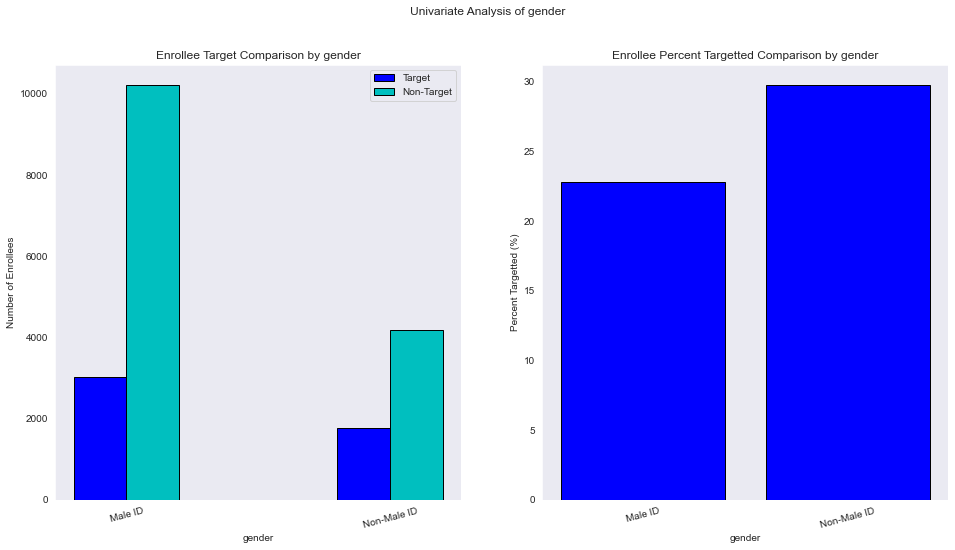

In [44]:
univar('gender')

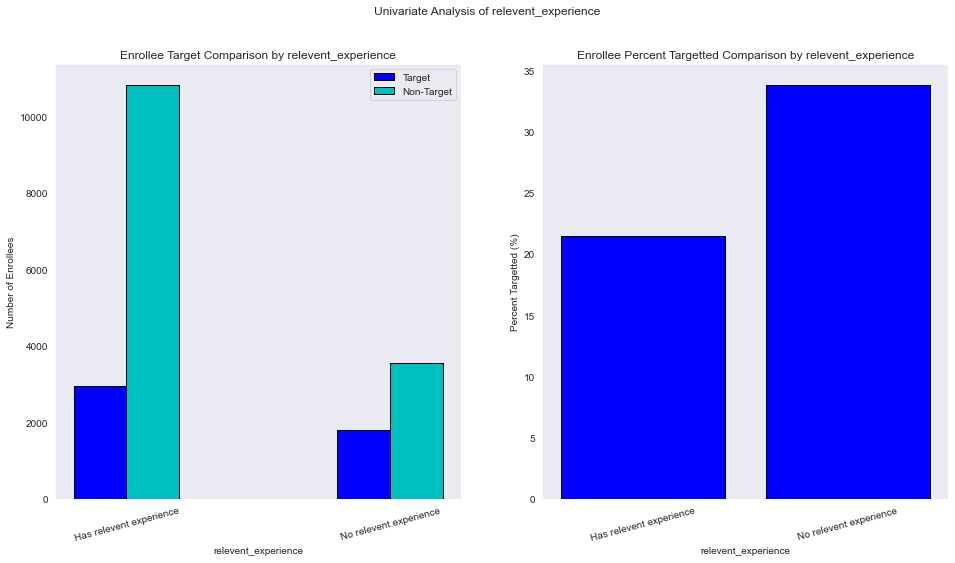

In [45]:
univar('relevent_experience')

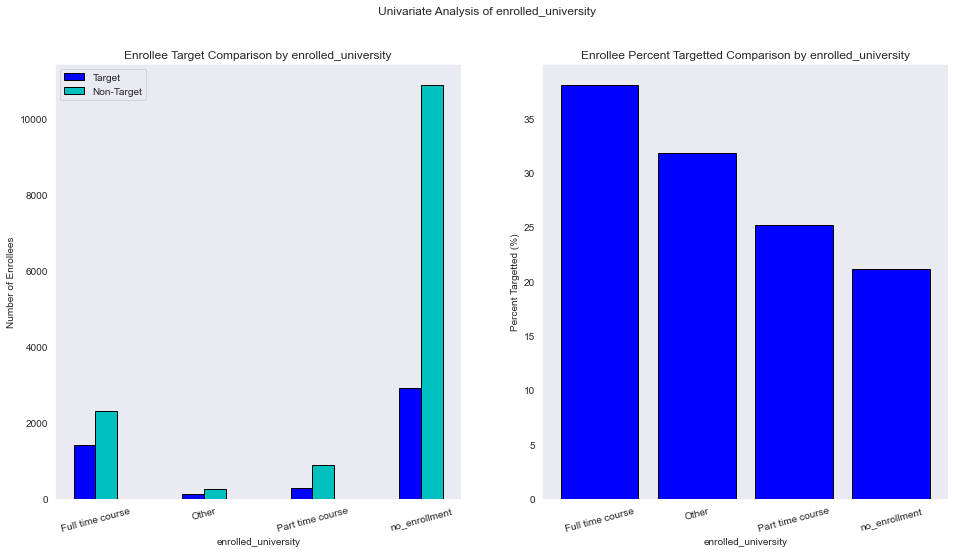

In [46]:
univar('enrolled_university')

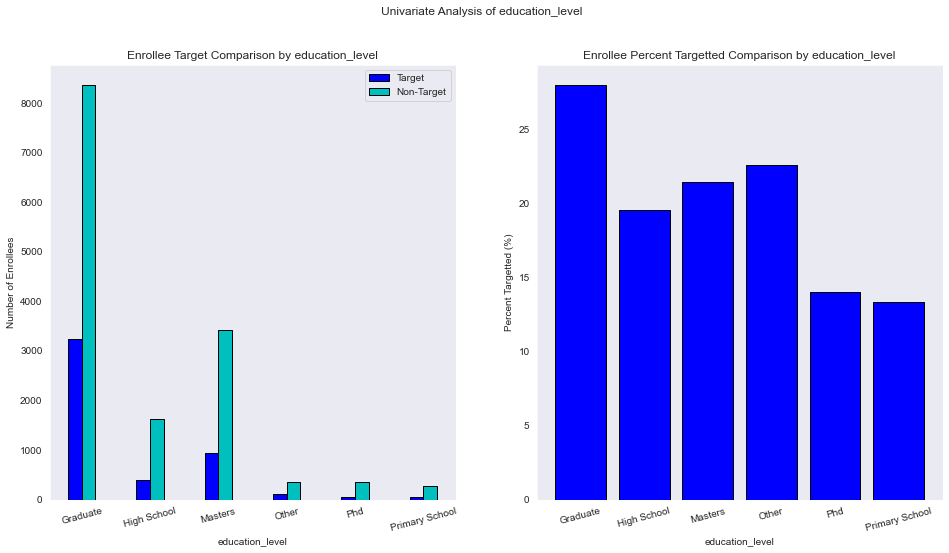

In [47]:
univar('education_level')

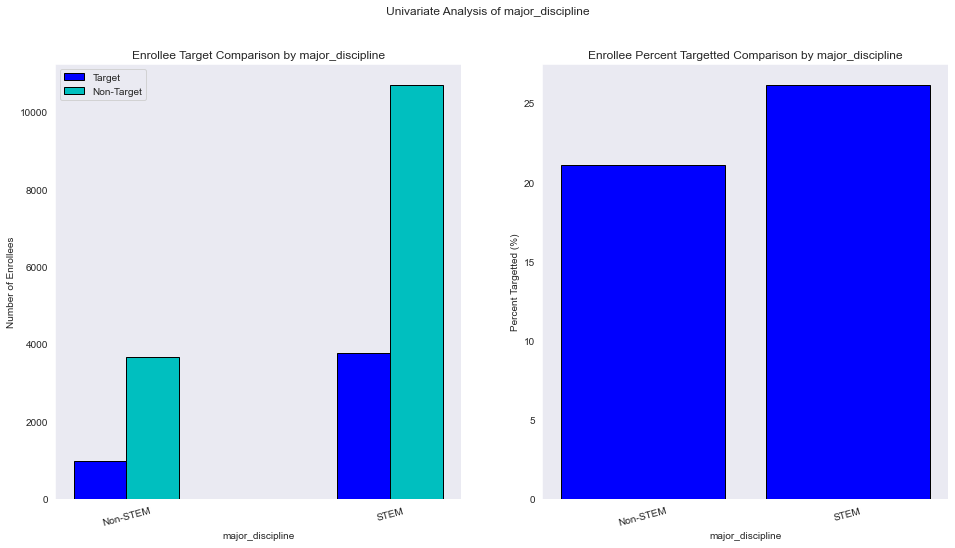

In [48]:
univar('major_discipline')

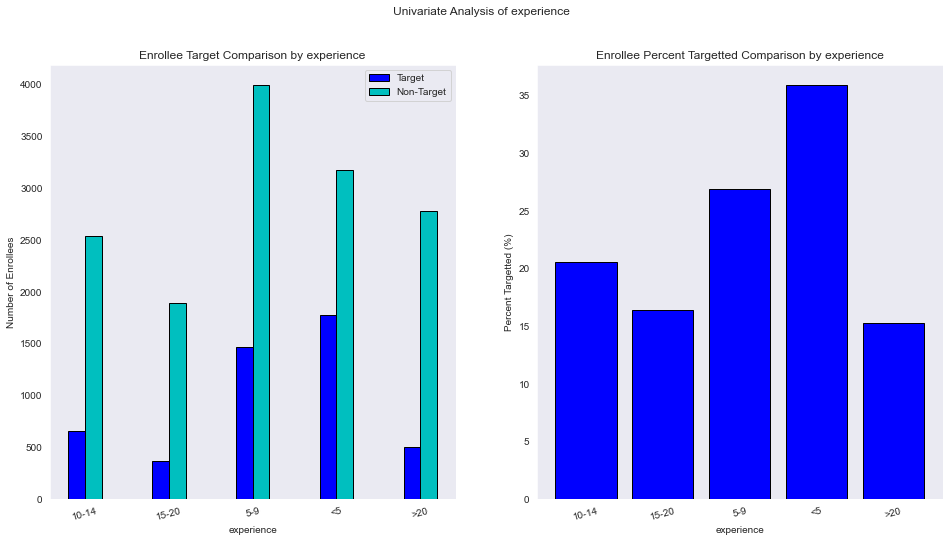

In [49]:
univar('experience')

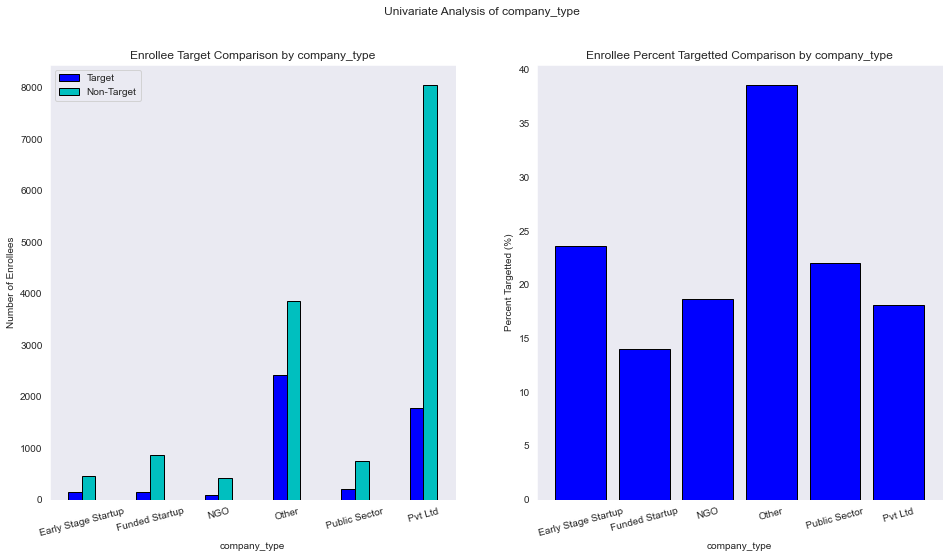

In [50]:
univar('company_type')

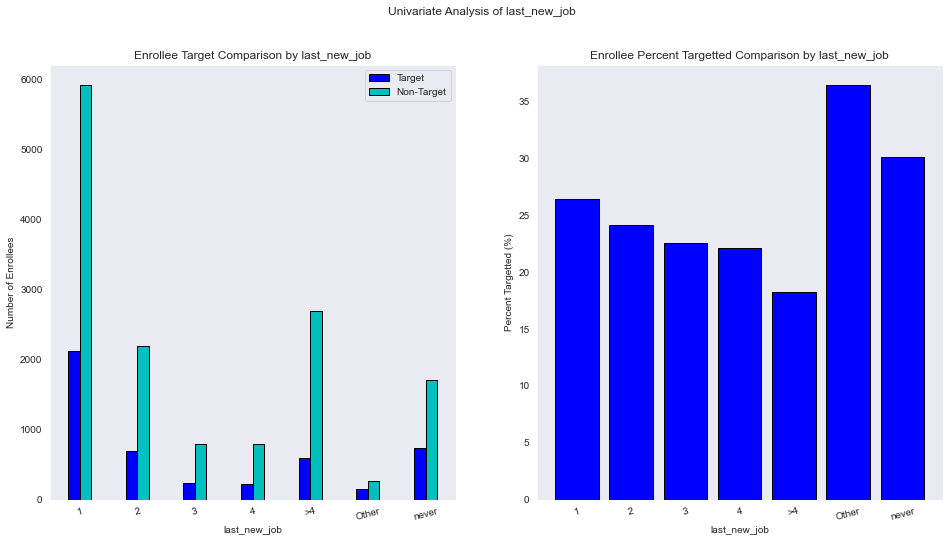

In [51]:
univar('last_new_job')

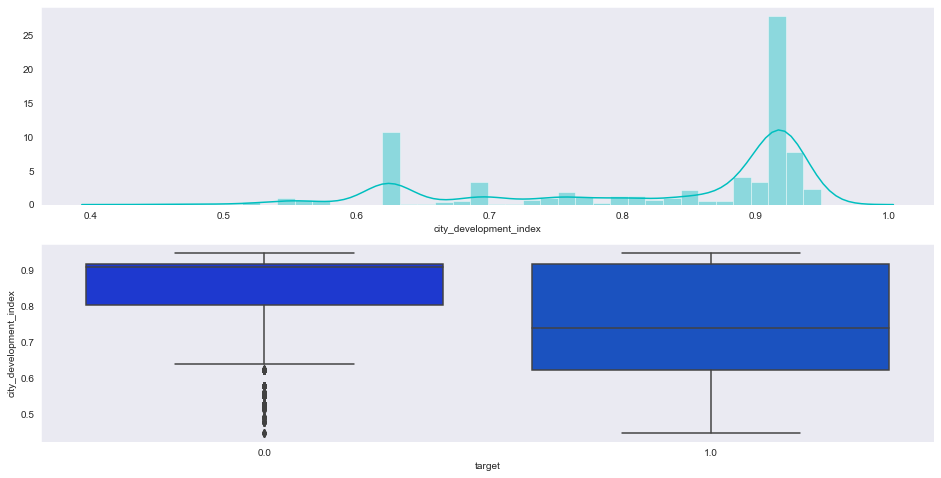

In [52]:
plt.figure(figsize=(16,8))

plt.subplot(2,1,1)
sns.distplot(hrTrain['city_development_index'], color = 'c')
plt.subplot(2,1,2)
sns.boxplot(y=hrTrain['city_development_index'], x = hrTrain['target'])
plt.show()

insert qualitative index here

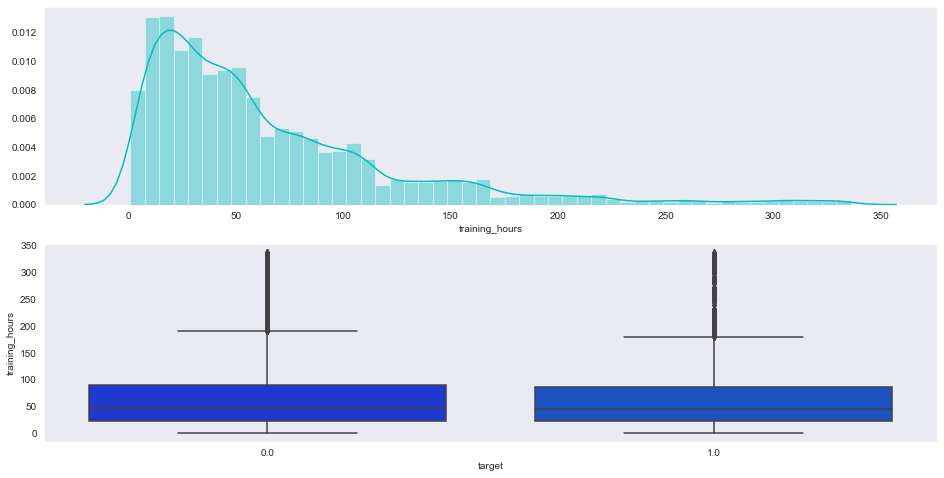

In [53]:
plt.figure(figsize=(16,8))

plt.subplot(2,1,1)
sns.distplot(hrTrain['training_hours'], color = 'c')
plt.subplot(2,1,2)
sns.boxplot(y = hrTrain['training_hours'], x = hrTrain['target'])
plt.show()

In [54]:
q95 = hrTrain['training_hours'].quantile(0.95)
hrTrain.loc[hrTrain['training_hours'] >= q95, 'training_hours'] = q95

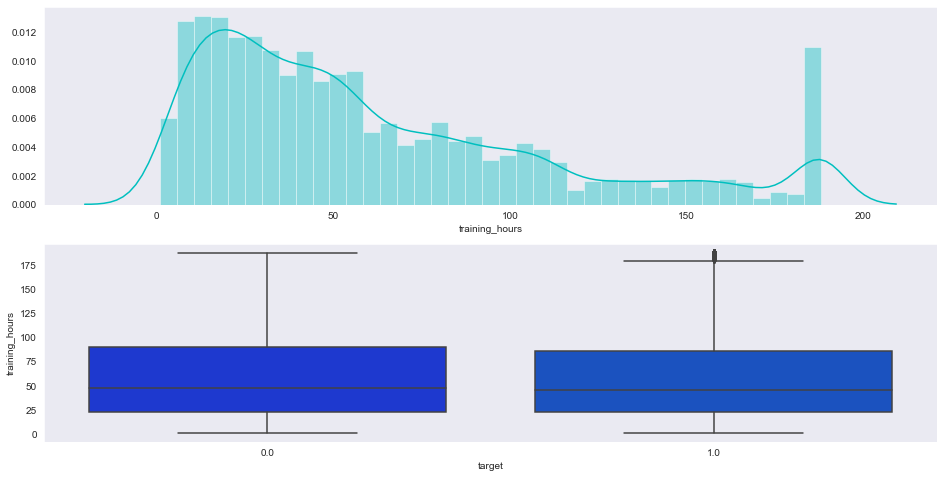

In [55]:
plt.figure(figsize=(16,8))

plt.subplot(2,1,1)
sns.distplot(hrTrain['training_hours'], color = 'c')
plt.subplot(2,1,2)
sns.boxplot(y = hrTrain['training_hours'], x = hrTrain['target'])
plt.show()

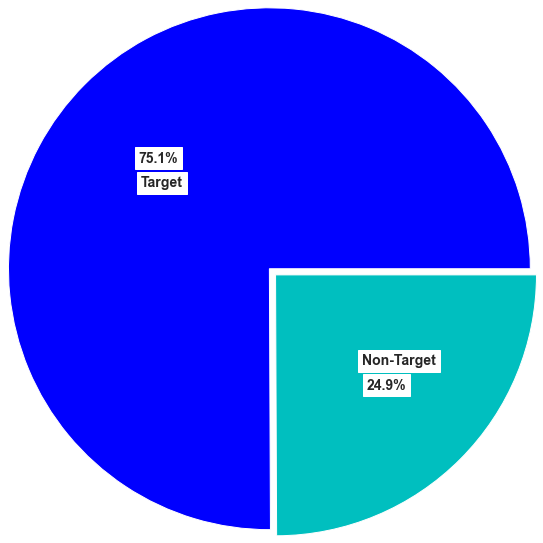

In [56]:
targetCounts = hrTrain['target'].value_counts().to_frame('counts')
plt.pie(targetCounts.counts, explode = (0, 0.1), labels = ['Non-Target', 'Target'], autopct='%1.1f%%', radius = 3, labeldistance = -0.5, colors = ['b', 'c'], textprops={'fontsize': 14, 'backgroundcolor': 'w', 'weight': 'bold'})
plt.show()

### Data Prep

In [57]:
hrTrain

,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_type,last_new_job,training_hours,target
0,0.920,Male ID,Has relevent experience,no_enrollment,Graduate,STEM,>20,Other,1,36.0,1.0
1,0.776,Male ID,No relevent experience,no_enrollment,Graduate,STEM,15-20,Pvt Ltd,>4,47.0,0.0
2,0.624,Non-Male ID,No relevent experience,Full time course,Graduate,STEM,5-9,Other,never,83.0,0.0
3,0.789,Non-Male ID,No relevent experience,Other,Graduate,Non-STEM,<5,Pvt Ltd,never,52.0,1.0
4,0.767,Male ID,Has relevent experience,no_enrollment,Masters,STEM,>20,Funded Startup,4,8.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
19153,0.878,Male ID,No relevent experience,no_enrollment,Graduate,Non-STEM,10-14,Other,1,42.0,1.0
19154,0.920,Male ID,Has relevent experience,no_enrollment,Graduate,STEM,10-14,Other,4,52.0,1.0
19155,0.920,Male ID,Has relevent experience,no_enrollment,Graduate,STEM,>20,Pvt Ltd,4,44.0,0.0
19156,0.802,Male ID,Has relevent experience,no_enrollment,High School,Non-STEM,<5,Pvt Ltd,2,97.0,0.0


In [58]:
hrTrain = pd.get_dummies(hrTrain, drop_first = True)
hrTest = pd.get_dummies(hrTest, drop_first = True)
hrTrain

,city_development_index,training_hours,target,gender_Non-Male ID,relevent_experience_No relevent experience,enrolled_university_Other,enrolled_university_Part time course,enrolled_university_no_enrollment,education_level_High School,education_level_Masters,...,company_type_NGO,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd,last_new_job_2,last_new_job_3,last_new_job_4,last_new_job_>4,last_new_job_Other,last_new_job_never
0,0.920,36.0,1.0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0.776,47.0,0.0,0,1,0,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
2,0.624,83.0,0.0,1,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
3,0.789,52.0,1.0,1,1,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,0.767,8.0,0.0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19153,0.878,42.0,1.0,0,1,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
19154,0.920,52.0,1.0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,1,0,0,0
19155,0.920,44.0,0.0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,0
19156,0.802,97.0,0.0,0,0,0,0,1,1,0,...,0,0,0,1,1,0,0,0,0,0


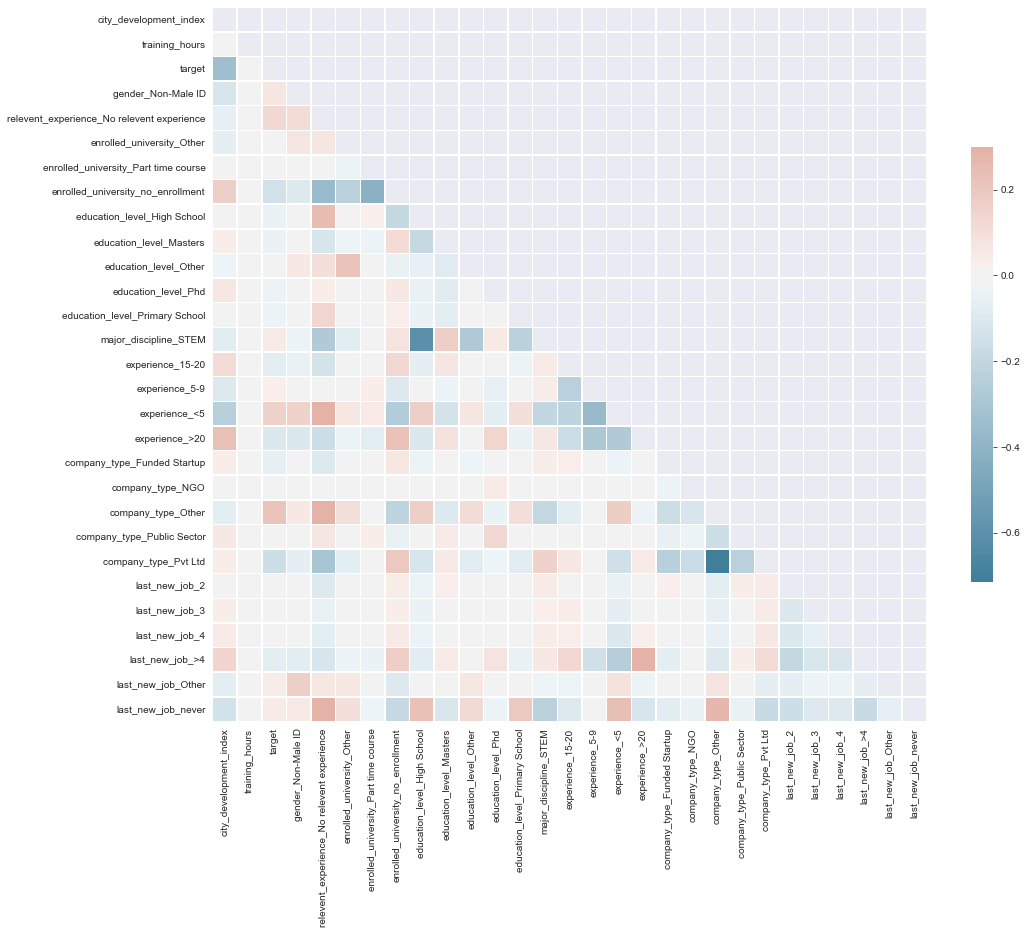

In [59]:
corr = hrTrain.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

plt.figure(figsize = (16,16))
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [60]:
corrTrain = hrTrain.corr()
corrDF = corrTrain.unstack().reset_index()
corrDF.columns = ['VAR1', 'VAR2', 'Correlation']
corrDF = corrDF[corrDF.Correlation != 1.0]
corrDF = corrDF[corrDF.Correlation != -1.0]
corrDF.sort_values(by='Correlation', ascending=False, inplace=True)
corrDF

,VAR1,VAR2,Correlation
144,relevent_experience_No relevent experience,last_new_job_never,0.370292
816,last_new_job_never,relevent_experience_No relevent experience,0.370292
584,company_type_Other,relevent_experience_No relevent experience,0.354971
136,relevent_experience_No relevent experience,company_type_Other,0.354971
468,experience_<5,relevent_experience_No relevent experience,0.352570
...,...,...,...
181,enrolled_university_Part time course,enrolled_university_no_enrollment,-0.415404
385,major_discipline_STEM,education_level_High School,-0.604542
245,education_level_High School,major_discipline_STEM,-0.604542
658,company_type_Pvt Ltd,company_type_Other,-0.714283


In [61]:
scaler = StandardScaler()
hrTrain[['city_development_index', 'training_hours']] = scaler.fit_transform(hrTrain[['city_development_index', 'training_hours']])
hrTest[['city_development_index', 'training_hours']] = scaler.fit_transform(hrTest[['city_development_index', 'training_hours']])

In [62]:
X = hrTrain.drop(['target'], axis = 1)
Y = pd.DataFrame(hrTrain['target'])

overSample = SMOTE(random_state = 12)
Xsm, Ysm = overSample.fit_resample(X, Y)

Before resampling there were 14381 NON_TARGETTED enrollees
Before resampling there were 4777 TARGETTED enrollees
After resampling there were 14381 NON_TARGETTED enrollees
After resampling there were 14381 TARGETTED enrollees


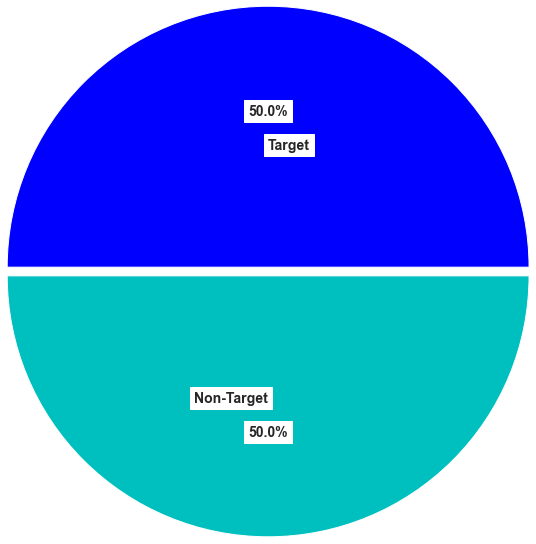

In [63]:
print(f"Before resampling there were {len(Y.loc[(Y['target'] == 0.0)])} NON_TARGETTED enrollees")
print(f"Before resampling there were {len(Y.loc[(Y['target'] == 1.0)])} TARGETTED enrollees")
print(f"After resampling there were {len(Ysm.loc[(Ysm['target'] == 0.0)])} NON_TARGETTED enrollees")
print(f"After resampling there were {len(Ysm.loc[(Ysm['target'] == 1.0)])} TARGETTED enrollees")

targetCountsSM = Ysm['target'].value_counts()
plt.pie(targetCountsSM, explode = (0, 0.1), labels = ['Non-Target', 'Target'], autopct='%1.1f%%', radius = 3, labeldistance = -0.5, colors = ['b', 'c'], textprops={'fontsize': 14, 'backgroundcolor': 'w', 'weight': 'bold'})
plt.show()

RFECV

In [64]:
%%time
estimator = LogisticRegression()
selector = RFECV(estimator, step = 1, cv = 5)
selector = selector.fit(Xsm, Ysm)

Wall time: 8.07 s


In [65]:
list(zip(Xsm.columns, selector.support_, selector.ranking_))

[('city_development_index', True, 1),
 ('training_hours', False, 15),
 ('gender_Non-Male ID', False, 14),
 ('relevent_experience_No relevent experience', False, 13),
 ('enrolled_university_Other', True, 1),
 ('enrolled_university_Part time course', True, 1),
 ('enrolled_university_no_enrollment', True, 1),
 ('education_level_High School', True, 1),
 ('education_level_Masters', True, 1),
 ('education_level_Other', True, 1),
 ('education_level_Phd', True, 1),
 ('education_level_Primary School', True, 1),
 ('major_discipline_STEM', False, 5),
 ('experience_15-20', False, 6),
 ('experience_5-9', False, 11),
 ('experience_<5', False, 16),
 ('experience_>20', False, 8),
 ('company_type_Funded Startup', True, 1),
 ('company_type_NGO', True, 1),
 ('company_type_Other', False, 4),
 ('company_type_Public Sector', True, 1),
 ('company_type_Pvt Ltd', True, 1),
 ('last_new_job_2', False, 10),
 ('last_new_job_3', False, 9),
 ('last_new_job_4', False, 7),
 ('last_new_job_>4', False, 12),
 ('last_new_

In [66]:
Xsm.columns[selector.support_]

Index(['city_development_index', 'enrolled_university_Other',
       'enrolled_university_Part time course',
       'enrolled_university_no_enrollment', 'education_level_High School',
       'education_level_Masters', 'education_level_Other',
       'education_level_Phd', 'education_level_Primary School',
       'company_type_Funded Startup', 'company_type_NGO',
       'company_type_Public Sector', 'company_type_Pvt Ltd'],
      dtype='object')

In [67]:
Xsm.columns[~selector.support_]

Index(['training_hours', 'gender_Non-Male ID',
       'relevent_experience_No relevent experience', 'major_discipline_STEM',
       'experience_15-20', 'experience_5-9', 'experience_<5', 'experience_>20',
       'company_type_Other', 'last_new_job_2', 'last_new_job_3',
       'last_new_job_4', 'last_new_job_>4', 'last_new_job_Other',
       'last_new_job_never'],
      dtype='object')

In [68]:
Xrfe = Xsm.drop(Xsm.columns[~selector.support_], axis = 1)
Xrfe

,city_development_index,enrolled_university_Other,enrolled_university_Part time course,enrolled_university_no_enrollment,education_level_High School,education_level_Masters,education_level_Other,education_level_Phd,education_level_Primary School,company_type_Funded Startup,company_type_NGO,company_type_Public Sector,company_type_Pvt Ltd
0,0.738919,0,0,1,0,0,0,0,0,0,0,0,0
1,-0.428410,0,0,1,0,0,0,0,0,0,0,0,1
2,-1.660590,0,0,0,0,0,0,0,0,0,0,0,0
3,-0.323026,1,0,0,0,0,0,0,0,0,0,0,1
4,-0.501368,0,0,1,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28757,-2.243728,0,0,1,0,0,0,0,0,0,0,0,0
28758,-1.640433,0,0,0,0,0,1,0,0,0,0,0,0
28759,-1.660590,0,0,1,0,0,0,0,0,0,0,0,0
28760,0.089842,0,0,1,0,1,0,0,0,0,0,0,0


In [69]:
testXrfe = hrTest.drop(Xsm.columns[~selector.support_], axis = 1)

Logistic Regression

In [70]:
def buildLogit(X, Y):
    X_const = sm.add_constant(X)
    hrModel = sm.Logit(Y, X_const).fit()
    display(hrModel.summary())
    return hrModel

In [71]:
def buildVIF(X):
    vif = pd.DataFrame()
    vif['Category'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'],2)
    vif.sort_values(by='VIF', ascending = False, inplace=True)
    return vif

In [72]:
x1 = Xsm
hrModel1 = buildLogit(x1, Ysm)

Optimization terminated successfully.
         Current function value: 0.552018
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                28762
Model:                          Logit   Df Residuals:                    28733
Method:                           MLE   Df Model:                           28
Date:                Mon, 01 Mar 2021   Pseudo R-squ.:                  0.2036
Time:                        18:54:03   Log-Likelihood:                -15877.
converged:                       True   LL-Null:                       -19936.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================================================
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
const                                          1.6309      0.092     17.702      0.000       1.450       1.811
city_development_index                        -0.7710      0.015    -52.639      0.000      -0.800      -0.742
training_hours                                -0.0803      0.014     -5.712      0.000      -0.108      -0.053
gender_Non-Male ID                            -0.1046      0.031     -3.392      0.001      -0.165      -0.044
relevent_experience_No relevent experience     0.1560      0.038      4.068      0.000       0.081       0.231
enrolled_university_Other                     -1.0651      0.114     -9.314      0.000      -1.289      -0.841
enrolled_university_Part time course          -0.8995      0.066    -13.565      0.000      -1.030      -0.770
enrolled_university_no_enrollment             -0.5667      0.038    -15.001      0.000      -0.641      -0.493
education_level_High School                   -1.4952      0.065    -22.910      0.000      -1.623      -1.367
education_level_Masters                       -0.4950      0.035    -14.074      0.000      -0.564      -0.426
education_level_Other                         -1.6222      0.113    -14.378      0.000      -1.843      -1.401
education_level_Phd                           -0.9210      0.128     -7.184      0.000      -1.172      -0.670
education_level_Primary School                -2.2641      0.159    -14.281      0.000      -2.575      -1.953
major_discipline_STEM                         -0.3432      0.045     -7.679      0.000      -0.431      -0.256
experience_15-20                              -0.4122      0.055     -7.509      0.000      -0.520      -0.305
experience_5-9                                -0.2186      0.042     -5.246      0.000      -0.300      -0.137
experience_<5                                 -0.0777      0.045     -1.713      0.087      -0.167       0.011
experience_>20                                -0.3147      0.051     -6.208      0.000      -0.414      -0.215
company_type_Funded Startup                   -1.3713      0.096    -14.240      0.000      -1.560      -1.183
company_type_NGO                              -1.3370      0.120    -11.164      0.000      -1.572      -1.102
company_type_Other                             0.3698      0.070      5.270      0.000       0.232       0.507
company_type_Public Sector                    -0.5534      0.092     -6.013      0.000      -0.734      -0.373
company_type_Pvt Ltd                          -0.8967      0.069    -13.044      0.000      -1.031      -0.762
last_new_job_2                                -0.2507      0.042     -6.023      0.000      -0.332      -0.169
last_new_job_3                                -0.3467      0.067     -5.141      0.000      -0.479      -0.215
last_new_job_4                                -0.3689      0.069     -5.319      0.000      -0.505      -0.233
last_new_job_>4       

In [73]:
buildVIF(x1)

,Category,VIF
21,company_type_Pvt Ltd,6.54
12,major_discipline_STEM,6.46
19,company_type_Other,5.49
6,enrolled_university_no_enrollment,4.34
15,experience_<5,2.89
14,experience_5-9,2.50
3,relevent_experience_No relevent experience,2.27
16,experience_>20,1.97
7,education_level_High School,1.80
25,last_new_job_>4,1.64


In [74]:
x2 = Xrfe
hrModel2 = buildLogit(x2, Ysm)

Optimization terminated successfully.
         Current function value: 0.560784
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                28762
Model:                          Logit   Df Residuals:                    28748
Method:                           MLE   Df Model:                           13
Date:                Mon, 01 Mar 2021   Pseudo R-squ.:                  0.1910
Time:                        18:54:04   Log-Likelihood:                -16129.
converged:                       True   LL-Null:                       -19936.
Covariance Type:            nonrobust   LLR p-value:                     0.000
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                    1.3382      0.034     39.262      0.000       1.271       1.405
city_development_index                  -0.7516      0.013    -56.302      0.000      -0.778      -0.725
enrolled_university_Other               -1.1351      0.113    -10.089      0.000      -1.356      -0.915
enrolled_university_Part time course    -0.8740      0.065    -13.470      0.000      -1.001      -0.747
enrolled_university_no_enrollment       -0.6004      0.034    -17.531      0.000      -0.668      -0.533
education_level_High School             -1.2329      0.051    -24.119      0.000      -1.333      -1.133
education_level_Masters                 -0.5172      0.034    -15.024      0.000      -0.585      -0.450
education_level_Other                   -1.4195      0.104    -13.673      0.000      -1.623      -1.216
education_level_Phd                     -0.9928      0.126     -7.886      0.000      -1.239      -0.746
education_level_Primary School          -2.0986      0.151    -13.909      0.000      -2.394      -1.803
company_type_Funded Startup             -1.6392      0.073    -22.324      0.000      -1.783      -1.495
company_type_NGO                        -1.5790      0.101    -15.618      0.000      -1.777      -1.381
company_type_Public Sector              -0.8241      0.067    -12.359      0.000      -0.955      -0.693
company_type_Pvt Ltd                    -1.2281      0.031    -40.192      0.000      -1.288      -1.168
========================================================================================================
"""

In [75]:
buildVIF(x2)

,Category,VIF
3,enrolled_university_no_enrollment,2.36
12,company_type_Pvt Ltd,2.06
5,education_level_Masters,1.28
9,company_type_Funded Startup,1.10
2,enrolled_university_Part time course,1.09
11,company_type_Public Sector,1.09
1,enrolled_university_Other,1.07
6,education_level_Other,1.07
7,education_level_Phd,1.05
4,education_level_High School,1.04


In [76]:
x1_train, x1_val, y1_train, y1_val = train_test_split(Xrfe, Ysm, test_size = 0.3, random_state = 12)

timedResultList = []

In [77]:
start = time.time()
timeResultsData = []

logXrfe = LogisticRegressionCV(Cs = 10, cv = 5, random_state = 12).fit(x1_train, y1_train)

y1_train_pred1 = logXrfe.predict(x1_train)
y1_val_pred1 = logXrfe.predict(x1_val)

trainScore1 = accuracy_score(y1_train, y1_train_pred1)
valScore1 = accuracy_score(y1_val, y1_val_pred1)
precScore1 = precision_score(y1_val, y1_val_pred1)
recScore1 = recall_score(y1_val, y1_val_pred1)

end = time.time()
timeResultsData.append('Log Reg')
timeResultsData.append(trainScore1)
timeResultsData.append(valScore1)
timeResultsData.append(precScore1)
timeResultsData.append(recScore1)
totalTime = round(end - start,2)
timeResultsData.append(totalTime)
timedResultList.append(timeResultsData)

print(f"Time: {totalTime} seconds")
print(f"Accuracy score of the train set: {trainScore1}")
print(f"Accuracy score of the valuation set: {valScore1}")
print(f"Precision score of the valuation set: {precScore1}")
print(f"Recall score of the valuation set: {recScore1}")

Time: 0.62 seconds
Accuracy score of the train set: 0.7381910296528088
Accuracy score of the valuation set: 0.7358906014601924
Precision score of the valuation set: 0.7259358288770054
Recall score of the valuation set: 0.7564429997678198


Support Vector Machine

In [78]:
start = time.time()
timeResultsData = []

svcXrfe = SVC(C = 10, random_state = 12, probability = True).fit(x1_train, y1_train)

y1_train_pred2 = svcXrfe.predict(x1_train)
y1_val_pred2 = svcXrfe.predict(x1_val)

trainScore2 = accuracy_score(y1_train, y1_train_pred2)
valScore2 = accuracy_score(y1_val, y1_val_pred2)
precScore2 = precision_score(y1_val, y1_val_pred2)
recScore2 = recall_score(y1_val, y1_val_pred2)

end = time.time()
timeResultsData.append('SVC')
timeResultsData.append(trainScore2)
timeResultsData.append(valScore2)
timeResultsData.append(precScore2)
timeResultsData.append(recScore2)
totalTime = round(end - start,2)
timeResultsData.append(totalTime)
timedResultList.append(timeResultsData)

print(f"Time: {totalTime} seconds")
print(f"Accuracy score of the train set: {trainScore2}")
print(f"Accuracy score of the valuation set: {valScore2}")
print(f"Precision score of the valuation set: {precScore2}")
print(f"Recall score of the valuation set: {recScore2}")

Time: 200.94 seconds
Accuracy score of the train set: 0.7570655143297075
Accuracy score of the valuation set: 0.752578514312203
Precision score of the valuation set: 0.7481718464351006
Recall score of the valuation set: 0.760157882516833


In [79]:
train_accuracies = []
test_accuracies = []
K_values = []

if (os.path.exists('preRunModels/trainAccuracies.joblib') & os.path.exists('preRunModels/testAccuracies.joblib') & os.path.exists('preRunModels/kValues.joblib')):
    train_accuracies = joblib.load('preRunModels/trainAccuracies.joblib')
    test_accuracies = joblib.load('preRunModels/testAccuracies.joblib')
    K_values = joblib.load('preRunModels/kValues.joblib')
    print("Pre-run model will be loaded")
else:
    for k in range(1, x1_train.shape[0],100):

        knnXrfe = KNeighborsClassifier(n_neighbors=k).fit(x1_train, y1_train)

        y_train_pred = knnXrfe.predict(x1_train)
        y_test_pred = knnXrfe.predict(x1_val)

        train_accuracies.append(accuracy_score(y1_train, y_train_pred))
        test_accuracies.append(accuracy_score(y1_val, y_test_pred))
        K_values.append(k)

        print(f"K={k}/{x1_train.shape[0]}", end="\r")
    
    joblib.dump(train_accuracies, 'preRunModels/trainAccuracies.joblib')
    joblib.dump(test_accuracies, 'preRunModels/testAccuracies.joblib')
    joblib.dump(K_values, 'preRunModels/kValues.joblib')

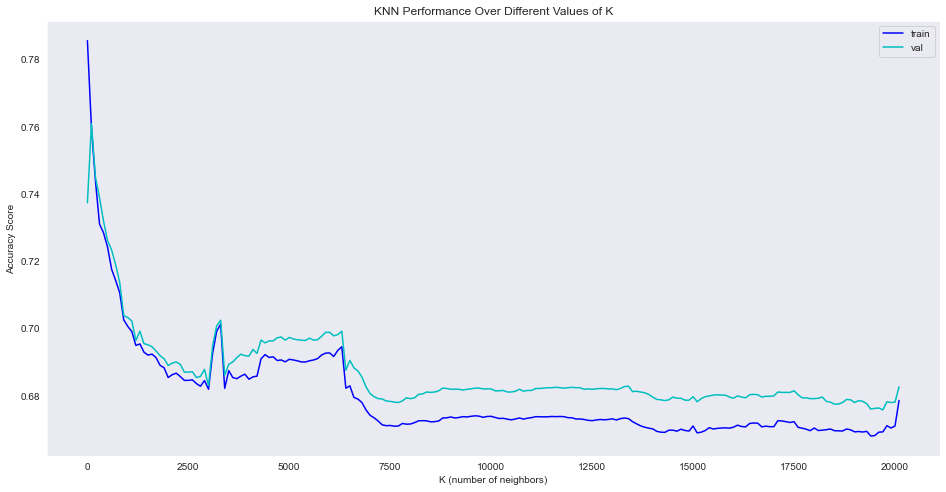

The highest train accuracy occured with a number of neighbors equal to: 101


In [80]:
plt.figure(figsize=(16,8))
plt.plot(K_values, train_accuracies, label="train", color = 'b')
plt.plot(K_values, test_accuracies, label="val", color = 'c')
plt.xlabel("K (number of neighbors)")
plt.ylabel("Accuracy Score")
plt.title("KNN Performance Over Different Values of K")
plt.legend()
plt.show()
print(f"The highest train accuracy occured with a number of neighbors equal to: {K_values[test_accuracies.index(max(test_accuracies))]}")

In [81]:
train_accuracies2 = []
test_accuracies2 = []
K_values2 = []

if (os.path.exists('preRunModels/trainAccuracies2.joblib') & os.path.exists('preRunModels/testAccuracies2.joblib') & os.path.exists('preRunModels/kValues2.joblib')):
    train_accuracies2 = joblib.load('preRunModels/trainAccuracies2.joblib')
    test_accuracies2 = joblib.load('preRunModels/testAccuracies2.joblib')
    K_values2 = joblib.load('preRunModels/kValues2.joblib')
    print("Pre-run model will be loaded")
else:
    for k in range(1, 101):

            knnXrfe = KNeighborsClassifier(n_neighbors=k).fit(x1_train, y1_train)

            y_train_pred = knnXrfe.predict(x1_train)
            y_test_pred = knnXrfe.predict(x1_val)

            train_accuracies2.append(accuracy_score(y1_train, y_train_pred))
            test_accuracies2.append(accuracy_score(y1_val, y_test_pred))
            K_values2.append(k)

            print(f"K={k}/100", end="\r")
            
    joblib.dump(train_accuracies2, 'preRunModels/trainAccuracies2.joblib')
    joblib.dump(test_accuracies2, 'preRunModels/testAccuracies2.joblib')
    joblib.dump(K_values2, 'preRunModels/kValues2.joblib')

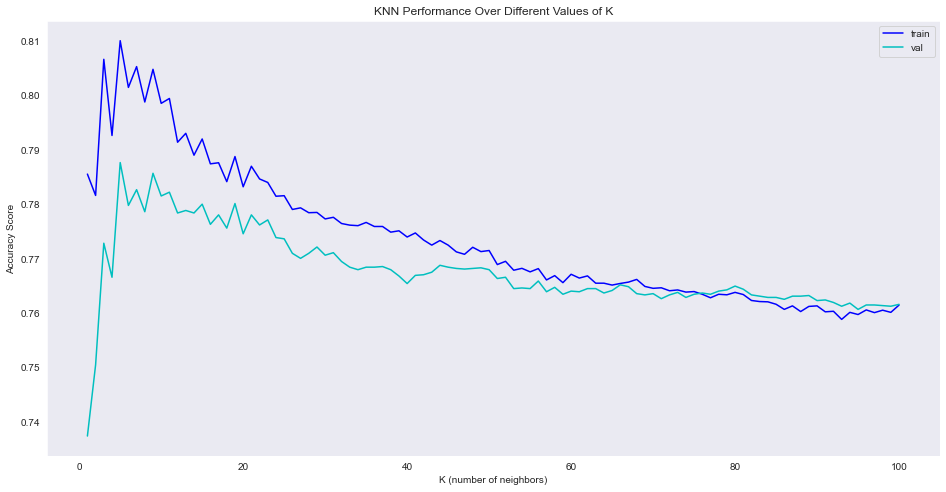

The highest train accuracy occured with a number of neighbors equal to: 5


In [82]:
plt.figure(figsize=(16,8))
plt.plot(K_values2, train_accuracies2, label="train", color = 'b')
plt.plot(K_values2, test_accuracies2, label="val", color = 'c')
plt.xlabel("K (number of neighbors)")
plt.ylabel("Accuracy Score")
plt.title("KNN Performance Over Different Values of K")
plt.legend()
plt.show()
print(f"The highest train accuracy occured with a number of neighbors equal to: {K_values2[test_accuracies2.index(max(test_accuracies2))]}")

In [83]:
start = time.time()
timeResultsData = []

knnXrfe = KNeighborsClassifier(n_neighbors = 5).fit(x1_train, y1_train)

y1_train_pred3 = knnXrfe.predict(x1_train)
y1_val_pred3 = knnXrfe.predict(x1_val)

trainScore3 = accuracy_score(y1_train, y1_train_pred3)
valScore3 = accuracy_score(y1_val, y1_val_pred3)
precScore3 = precision_score(y1_val, y1_val_pred3)
recScore3 = recall_score(y1_val, y1_val_pred3)

end = time.time()
timeResultsData.append('KNN')
timeResultsData.append(trainScore3)
timeResultsData.append(valScore3)
timeResultsData.append(precScore3)
timeResultsData.append(recScore3)
totalTime = round(end - start,2)
timeResultsData.append(totalTime)
timedResultList.append(timeResultsData)

print(f"Time: {totalTime} seconds")
print(f"Accuracy score of the train set: {trainScore3}")
print(f"Accuracy score of the valuation set: {valScore3}")
print(f"Precision score of the valuation set: {precScore3}")
print(f"Recall score of the valuation set: {recScore3}")

Time: 2.27 seconds
Accuracy score of the train set: 0.8101127502110962
Accuracy score of the valuation set: 0.7876926642716421
Precision score of the valuation set: 0.7875900534510807
Recall score of the valuation set: 0.7868586022753656


In [84]:
depths = np.arange(1, 51)
depth_value = []
train_accuracies = []
test_accuracies = []

for depth in depths:
    dtXrfe = DecisionTreeClassifier(max_depth = depth, random_state=12)
    dtXrfe.fit(x1_train, y1_train)
    
    y_train_pred = dtXrfe.predict(x1_train)
    y_test_pred = dtXrfe.predict(x1_val)

    train_accuracies.append(accuracy_score(y1_train, y_train_pred))
    test_accuracies.append(accuracy_score(y1_val, y_test_pred))
    depth_value.append(depth)

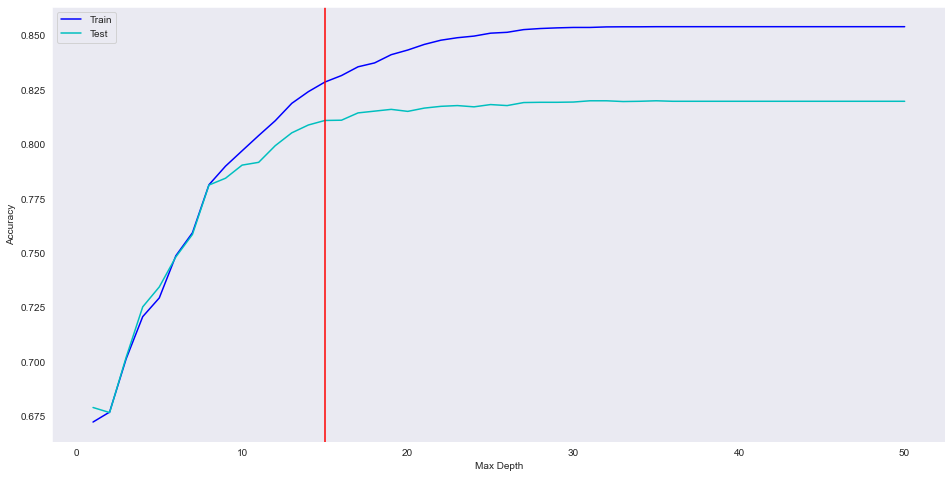

In [85]:
plt.figure(figsize = (16,8))
plt.plot(depth_value, train_accuracies, label="Train", color = 'b')
plt.plot(depth_value, test_accuracies, label="Test", color = 'c')
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.legend()

plt.axvline(x=15, color = 'red')
plt.show()

In [86]:
minSamples = np.arange(1, 20000)
min_value = []
train_accuracies3 = []
test_accuracies3 = []

if (os.path.exists('preRunModels/trainAccuracies3.joblib') & os.path.exists('preRunModels/testAccuracies3.joblib') & os.path.exists('preRunModels/minLeafValues.joblib')):
    train_accuracies3 = joblib.load('preRunModels/trainAccuracies3.joblib')
    test_accuracies3 = joblib.load('preRunModels/testAccuracies3.joblib')
    min_value = joblib.load('preRunModels/minLeafValues.joblib')
    print("Pre-run model will be loaded")
else:
    for minS in minSamples:
        dtXrfe = DecisionTreeClassifier(max_depth = 15, min_samples_leaf = minS, random_state=12)
        dtXrfe.fit(x1_train, y1_train)

        y_train_pred = dtXrfe.predict(x1_train)
        y_test_pred = dtXrfe.predict(x1_val)

        train_accuracies3.append(accuracy_score(y1_train, y_train_pred))
        test_accuracies3.append(accuracy_score(y1_val, y_test_pred))
        min_value.append(minS)

        print(f"min samples={minS}/20000", end="\r")
        
    joblib.dump(train_accuracies3, 'preRunModels/trainAccuracies3.joblib')
    joblib.dump(test_accuracies3, 'preRunModels/testAccuracies3.joblib')
    joblib.dump(min_value, 'preRunModels/minLeafValues.joblib')

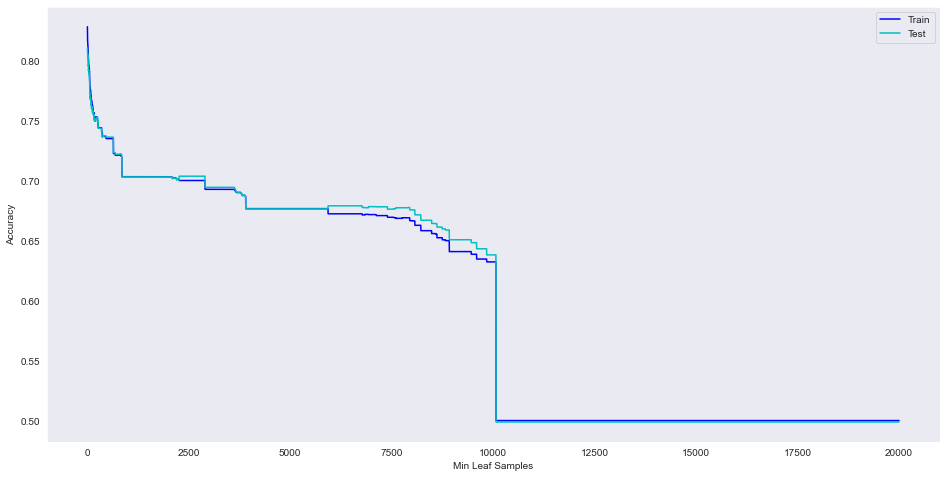

In [87]:
plt.figure(figsize = (16,8))
plt.plot(min_value, train_accuracies3, label="Train", color = 'b')
plt.plot(min_value, test_accuracies3, label="Test", color = 'c')
plt.xlabel("Min Leaf Samples")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [88]:
start = time.time()
timeResultsData = []

dtXrfe = DecisionTreeClassifier(max_depth = 15, random_state=12)
dtXrfe.fit(x1_train, y1_train)

y1_train_pred4 = dtXrfe.predict(x1_train)
y1_val_pred4 = dtXrfe.predict(x1_val)

trainScore4 = accuracy_score(y1_train, y1_train_pred4)
valScore4 = accuracy_score(y1_val, y1_val_pred4)
precScore4 = precision_score(y1_val, y1_val_pred4)
recScore4 = recall_score(y1_val, y1_val_pred4)

end = time.time()
timeResultsData.append('Tree')
timeResultsData.append(trainScore4)
timeResultsData.append(valScore4)
timeResultsData.append(precScore4)
timeResultsData.append(recScore4)
totalTime = round(end - start,2)
timeResultsData.append(totalTime)
timedResultList.append(timeResultsData)

print(f"Time: {totalTime} seconds")
print(f"Accuracy score of the train set: {trainScore4}")
print(f"Accuracy score of the valuation set: {valScore4}")
print(f"Precision score of the valuation set: {precScore4}")
print(f"Recall score of the valuation set: {recScore4}")

Time: 0.05 seconds
Accuracy score of the train set: 0.8286395470123677
Accuracy score of the valuation set: 0.8109862092942404
Precision score of the valuation set: 0.8036768043576941
Recall score of the valuation set: 0.8221499883909914


In [89]:
nEst = np.arange(1, 101)
estimator_value = []
train_accuracies4 = []
test_accuracies4 = []

if (os.path.exists('preRunModels/trainAccuracies4.joblib') & os.path.exists('preRunModels/testAccuracies4.joblib') & os.path.exists('preRunModels/nEstimatorValues.joblib')):
    train_accuracies4 = joblib.load('preRunModels/trainAccuracies4.joblib')
    test_accuracies4 = joblib.load('preRunModels/testAccuracies4.joblib')
    estimator_value = joblib.load('preRunModels/nEstimatorValues.joblib')
    print("Pre-run model will be loaded")
else:
    for est in nEst:
        rfXrfe = RandomForestClassifier(n_estimators = est)
        rfXrfe.fit(x1_train, y1_train)

        y_train_pred = rfXrfe.predict(x1_train)
        y_test_pred = rfXrfe.predict(x1_val)

        train_accuracies4.append(accuracy_score(y1_train, y_train_pred))
        test_accuracies4.append(accuracy_score(y1_val, y_test_pred))
        estimator_value.append(est)

        print(f"nEst={est}/100", end="\r")
        
    joblib.dump(train_accuracies4, 'preRunModels/trainAccuracies4.joblib')
    joblib.dump(test_accuracies4, 'preRunModels/testAccuracies4.joblib')
    joblib.dump(estimator_value, 'preRunModels/nEstimatorValues.joblib')

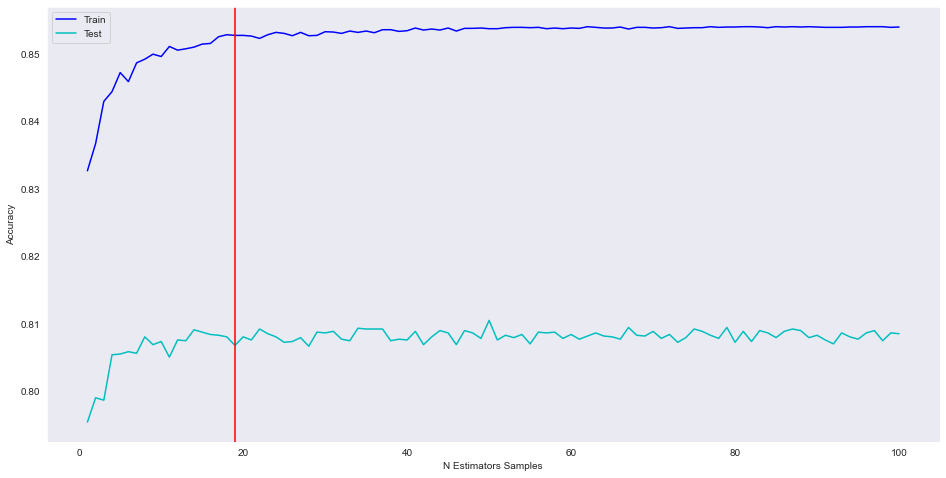

In [90]:
plt.figure(figsize = (16,8))
plt.plot(estimator_value, train_accuracies4, label="Train", color = 'b')
plt.plot(estimator_value, test_accuracies4, label="Test", color = 'c')
plt.xlabel("N Estimators Samples")
plt.ylabel("Accuracy")
plt.legend()

plt.axvline(x=19, color = 'red')
plt.show()

In [91]:
cv_scores = []
nEst = []

if (os.path.exists('preRunModels/cv_scores.joblib') & os.path.exists('preRunModels/nEst.joblib')):
    cv_scores = joblib.load('preRunModels/cv_scores.joblib')
    nEst = joblib.load('preRunModels/nEst.joblib')
    print("Pre-run model will be loaded")
else:
    for n in range(1,100):
        rfXfre = RandomForestClassifier(n_estimators = n)
        cv_score = np.mean(cross_val_score(rfXfre, x1_train, y1_train, cv=5))
        cv_scores.append(cv_score)
        nEst.append(n)
        
    joblib.dump(cv_scores, 'preRunModels/cv_scores.joblib')
    joblib.dump(nEst, 'preRunModels/nEst.joblib')

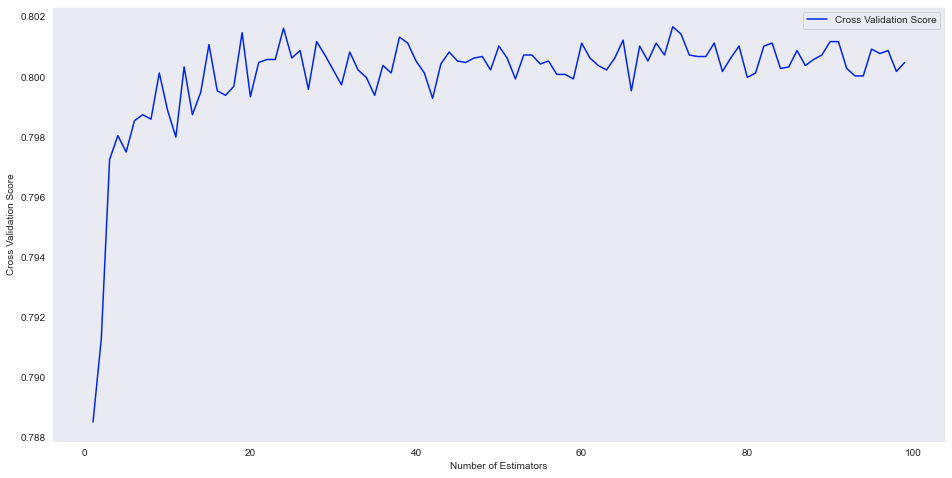

The highest train cross val score occured with a number of neighbors equal to: 71


In [92]:
plt.figure(figsize = (16,8))
plt.plot(nEst, cv_scores, label="Cross Validation Score")
plt.xlabel('Number of Estimators')
plt.ylabel('Cross Validation Score')
plt.legend()
plt.show()
bestNest = nEst[cv_scores.index(max(cv_scores))]
print(f"The highest train cross val score occured with a number of neighbors equal to: {bestNest}")

In [93]:
depth2 = np.arange(1, 51)
depth2_value = []
train_accuracies5 = []
test_accuracies5 = []

if (os.path.exists('preRunModels/trainAccuracies5.joblib') & os.path.exists('preRunModels/testAccuracies5.joblib') & os.path.exists('preRunModels/depth2Values.joblib')):
    train_accuracies5 = joblib.load('preRunModels/trainAccuracies5.joblib')
    test_accuracies5 = joblib.load('preRunModels/testAccuracies5.joblib')
    depth2_value = joblib.load('preRunModels/depth2Values.joblib')
    print("Pre-run model will be loaded")
else:
    for depth in depth2:
        rfXrfe = RandomForestClassifier(max_depth = depth)
        rfXrfe.fit(x1_train, y1_train)

        y_train_pred = rfXrfe.predict(x1_train)
        y_test_pred = rfXrfe.predict(x1_val)

        train_accuracies5.append(accuracy_score(y1_train, y_train_pred))
        test_accuracies5.append(accuracy_score(y1_val, y_test_pred))
        depth2_value.append(depth)

        print(f"depth={depth}/50", end="\r")
        
    joblib.dump(train_accuracies5, 'preRunModels/trainAccuracies5.joblib')
    joblib.dump(test_accuracies5, 'preRunModels/testAccuracies5.joblib')
    joblib.dump(depth2_value, 'preRunModels/depth2Values.joblib')

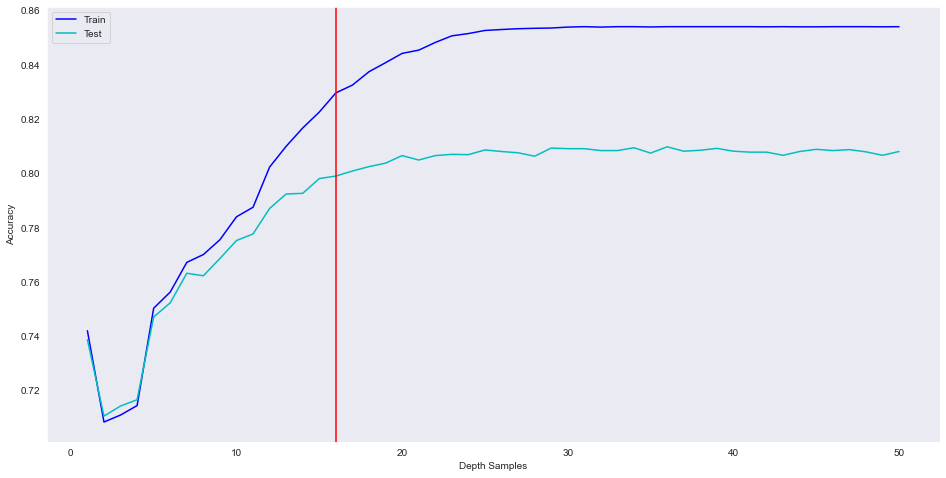

In [94]:
plt.figure(figsize = (16,8))
plt.plot(depth2_value, train_accuracies5, label="Train", color = 'b')
plt.plot(depth2_value, test_accuracies5, label="Test", color = 'c')
plt.xlabel("Depth Samples")
plt.ylabel("Accuracy")
plt.legend()

plt.axvline(x=16, color = 'red')
plt.show()

In [95]:
cv_scores2 = []
depth3 = []

if (os.path.exists('preRunModels/cv_scores2.joblib') & os.path.exists('preRunModels/depth3.joblib')):
    cv_scores2 = joblib.load('preRunModels/cv_scores2.joblib')
    depth3 = joblib.load('preRunModels/depth3.joblib')
    print("Pre-run model will be loaded")
else:
    for d in range(1,100):
        rfXfre = RandomForestClassifier(max_depth = d)
        cv_score = np.mean(cross_val_score(rfXfre, x1_train, y1_train, cv=5))
        cv_scores2.append(cv_score)
        depth3.append(d)
        
    joblib.dump(cv_scores2, 'preRunModels/cv_scores2.joblib')
    joblib.dump(depth3, 'preRunModels/depth3.joblib')

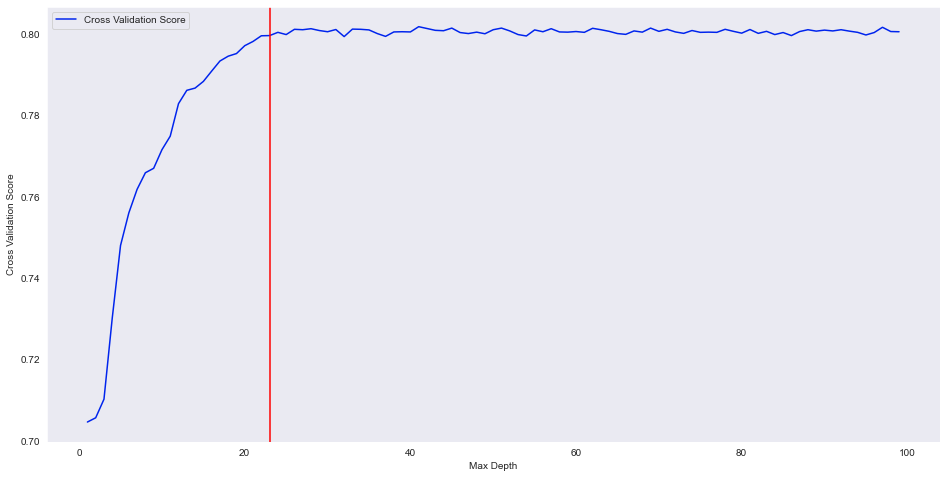

In [96]:
plt.figure(figsize = (16,8))
plt.plot(depth3, cv_scores2, label="Cross Validation Score")
plt.xlabel('Max Depth')
plt.ylabel('Cross Validation Score')
plt.legend()
plt.axvline(x = 23, color = 'red')
plt.show()

In [97]:
start = time.time()
timeResultsData = []

rfXrfe = RandomForestClassifier(n_estimators = bestNest, max_depth = 23, random_state=12)
rfXrfe.fit(x1_train, y1_train)

y1_train_pred5 = rfXrfe.predict(x1_train)
y1_val_pred5 = rfXrfe.predict(x1_val)

trainScore5 = accuracy_score(y1_train, y1_train_pred5)
valScore5 = accuracy_score(y1_val, y1_val_pred5)
precScore5 = precision_score(y1_val, y1_val_pred5)
recScore5 = recall_score(y1_val, y1_val_pred5)

end = time.time()
timeResultsData.append('Forrest')
timeResultsData.append(trainScore5)
timeResultsData.append(valScore5)
timeResultsData.append(precScore5)
timeResultsData.append(recScore5)
totalTime = round(end - start,2)
timeResultsData.append(totalTime)
timedResultList.append(timeResultsData)

print(f"Time: {totalTime} seconds")
print(f"Accuracy score of the train set: {trainScore5}")
print(f"Accuracy score of the valuation set: {valScore5}")
print(f"Precision score of the valuation set: {precScore5}")
print(f"Recall score of the valuation set: {recScore5}")

Time: 0.9 seconds
Accuracy score of the train set: 0.8504942134803556
Accuracy score of the valuation set: 0.80866844362035
Precision score of the valuation set: 0.8029197080291971
Recall score of the valuation set: 0.8172742047829116


In [98]:
estimatorBag = [
    ('LogisticRegression', logXrfe),
    ('SVC', svcXrfe),
    ('KNN', knnXrfe)
]

In [99]:
start = time.time()
timeResultsData = []

bagXrfe = VotingClassifier(estimators=estimatorBag, voting="soft", weights=[1,1,2])
bagXrfe.fit(x1_train, y1_train)

y1_train_pred6 = bagXrfe.predict(x1_train)
y1_val_pred6 = bagXrfe.predict(x1_val)

trainScore6 = accuracy_score(y1_train, y1_train_pred6)
valScore6 = accuracy_score(y1_val, y1_val_pred6)
precScore6 = precision_score(y1_val, y1_val_pred6)
recScore6 = recall_score(y1_val, y1_val_pred6)

end = time.time()
timeResultsData.append('Bag')
timeResultsData.append(trainScore6)
timeResultsData.append(valScore6)
timeResultsData.append(precScore6)
timeResultsData.append(recScore6)
totalTime = round(end - start,2)
timeResultsData.append(totalTime)
timedResultList.append(timeResultsData)

print(f"Time: {totalTime} seconds")
print(f"Accuracy score of the train set: {trainScore6}")
print(f"Accuracy score of the valuation set: {valScore6}")
print(f"Precision score of the valuation set: {precScore6}")
print(f"Recall score of the valuation set: {recScore6}")

Time: 227.57 seconds
Accuracy score of the train set: 0.802960313912482
Accuracy score of the valuation set: 0.7857225634488353
Precision score of the valuation set: 0.7835717581910475
Recall score of the valuation set: 0.788483863478059


In [100]:
timeDF = pd.DataFrame(timedResultList)
timeDF.columns = ['Model Type', 'Train Accuracy', 'Test Accuracy', 'Precision', 'Recall', 'Time (s)']
timeDF

,Model Type,Train Accuracy,Test Accuracy,Precision,Recall,Time (s)
0,Log Reg,0.738191,0.735891,0.725936,0.756443,0.62
1,SVC,0.757066,0.752579,0.748172,0.760158,200.94
2,KNN,0.810113,0.787693,0.787590,0.786859,2.27
3,Tree,0.828640,0.810986,0.803677,0.822150,0.05
4,Forrest,0.850494,0.808668,0.802920,0.817274,0.90
5,Bag,0.802960,0.785723,0.783572,0.788484,227.57


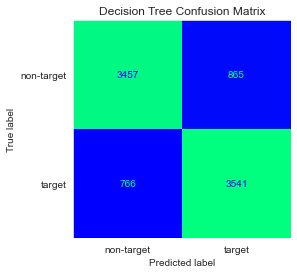

In [101]:
labels = ['non-target', 'target']
confMatrix = plot_confusion_matrix(dtXrfe, x1_val ,y1_val, cmap = 'winter', colorbar = False, display_labels= labels)
plt.title('Decision Tree Confusion Matrix')
plt.show(confMatrix)

In [102]:
testTargets = dtXrfe.predict(testXrfe)
testTargetsProb = dtXrfe.predict_proba(testXrfe)